# TP5 : Visualisation et recommandation

## Exercice 1 : Réduction de dimension

**Jeux de données :**
- Swiss Roll http://dac.lip6.fr/master/wp-content/uploads/2017/09/swiss_roll.csv
- Decathlon http://dac.lip6.fr/master/wp-content/uploads/2017/09/decathlon.csv (supprimer les
variables qualitatives, et renverser les temps de façon à avoir une valeur élevée pour les meilleurs
temps)
- MNIST

### Question 1
**Implémentez le modèle t-SNE.**

Implémentation inspirée de [Visualizing Data using t-SNE](http://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)

In [7]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import itertools
from sklearn import datasets
%matplotlib inline

class TSNE():
    def __init__(self, n_components=2, perplexity=30.0, n_iter=1000, learning_rate=200.0, ):
        # Parameters:
        self.n_components  = n_components
        self.perplexity    = perplexity
        self.n_iter        = n_iter
        self.learning_rate = learning_rate
        
        # Memoization:
        self.distances = None # squared distances, upper triangular matrix
        self.joint_p   = None # self.joint_p[i,j] = p(i, j)
        self.cond_p    = None # self.cond_p[i,j] = p(j|i)
        self.sigma     = None
    
    def get_dist(self, X, i, j):
        if self.distances is None:
            distances = np.zeros((X.shape[0], X.shape[0]))
            for k,l in itertools.combinations(range(X.shape[0]), 2):
                distances[k,l] = sum((X[k] - X[l])**2)
        self.distances = sparse.triu(distances)
        if i>j:
            i,j = j,i
        return self.distances[i,j]
        
    def get_cond_p(self, X, i, j):
        """ Return p(j|i). Find the sigma that fit the desired perplexity.
        Create the arrays of conditional probas and sigmas if they don't exist"""
        # Create the matrix if it doesn't exist:
        if self.cond_p is None:
            N = X.shape[0] # number of vectors
            self.cond_p = np.zeros((N, N))
            self.sigma = np.zeros(N)
            for k in range(N):
                # Find sigma
                self.sigma[k] = self.find_sigma(X, k)
                # Compute all conditional probabilities
                for l in range(N):
                    self.cond_p[k,l] = self.compute_conditional_p(X, k, l, self.sigma[k])
        
        return self.cond_p[i, j]
    
    def compute_conditional_p(self, X, i, j, sigma_i):
        """Returns p(j|i), used to find the sigmas that fit the perplexity"""
        if i == j:
            return 0
        numerator = np.exp(-self.get_dist(X, i, j)/(2 * sigma_i**2))
        denom = sum([np.exp(-self.get_dist(X, i, k)/(2 * sigma_i**2)) for k in range(X.shape[0])
                    if k != i])
        return numerator/denom    
    
    def find_sigma(self, X, i, max_iter=100):
        """Find sigma compomnent that gives the wanted perplexity"""
        sigmin = 1
        n = 0
        while n < max_iter and self.compute_perplexity(X, i, sigmin) > self.perplexity:
            sigmin /= 2
            n += 1
            
        n = 0
        while n < max_iter and self.compute_perplexity(X, i, sigmax) < self.perplexity:
            sigmax *= 2
            n += 1
        
        f = lambda s: self.compute_perplexity(X, i, s)
        sigma_i = scipy.optimize.bisect(f, sigmin, sigmax, maxiter=max_iter).x0
        return sigma_i

    def compute_perplexity(self, X, i, sigma_i):
        """ Returns the perplexity"""
        h = 0 # Shannon entropy of P_i
        for j in range(X.shape[0]):
            p = self.compute_conditional_p(X, i, j, sigma_i)
            h -= p * np.log2(p)
        return 2**h
        
    def get_joint_p(self, X, i, j):
        """ Return p_{ij}"""
        N = X.shape[0]        
        if self.joint_p is None:
            joint_p = np.array((N,N))
            for k,l in itertools.combinations_with_replacement(range(N), 2):
                joint_p[k,l] = (self.get_cond_p(X, k, l) + self.get_cond_p(X, l, k)) / (2*N)
        self.joint_p = sparse.triu(joint_p)
        if i>j:
            i,j = j,i
        return self.joint_p[i,j]
    
    def compute_joint_q(self, y, i, j):
        numerator = sum([(1+ sum((y[k] - y[l])**2)) 
                        for k,l in itertools.product(range(y.shape[0]), repeat=2)
                        if k != l])
        denom = 1 + sum((y[i] - y[j])**2)
        return numerator/denom
    
    def gradient_cost(self, X, y, i=None):
        N = X.shape[0]
        def grad_i(i):
            s = 0
            for j in range(N):
                s += (self.get_joint_p(X, i, j) -  self.compute_joint_q(y, i, j)) * \
                     (y[i] - y[j]) / (1 + sum((y[i]-y[j])**2))
            return 4*s

        if i is not None:
            return grad_i(i)
        else :
            return np.array([grad_i(i) for i in range(N)])
        
    
    def fit_transform(self, X):
        """ Return the low-dimensional representation of X."""
        # Sample initial solution y from a gaussian distribution
        y = np.random.random((X.shape[0], self.n_components))
        for t in range(self.n_iter):
            grad = self.gradient_cost(X, y)
            y += self.learning_rate * grad
        return y
    
    
iris = datasets.load_iris()
X, y = iris.data, iris.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Classes in y:", np.unique(y, return_counts=True))

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)
print("Shape of X_tsne:", X_tsne.shape)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)



Shape of X: (150, 4)
Shape of y: (150,)
Classes in y: (array([0, 1, 2]), array([50, 50, 50]))


/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in log2
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in double_scalars


TypeError: 'coo_matrix' object is not subscriptable

### Question 2
Construisez des visualisation (en 2D et en 3D) des jeux de données proposés (ou autres). 

Comparez avec d’autres méthodes de réduction de dimension, linéaires et non-linéaires (voir http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold).



Shape of X: (150, 4)
Shape of y: (150,)
Classes in y: (array([0, 1, 2]), array([50, 50, 50]))
Shape of X_tsne: (150, 2)


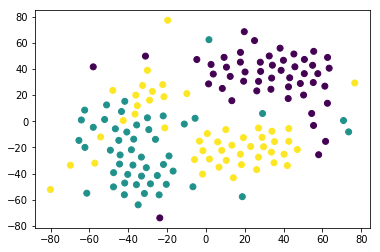

In [16]:
from sklearn import datasets
from sklearn import manifold

iris = datasets.load_iris()
X, y = iris.data, iris.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Classes in y:", np.unique(y, return_counts=True))

skl_tsne = manifold.TSNE(n_components = 2)
X_tsne = skl_tsne.fit_transform(X, y)
print("Shape of X_tsne:", X_tsne.shape)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)



Question 3
Pour Isomap et LLE, manipulez le paramètre contrôlant la taille du voisinage pour la construction du
graphe.
Exercice 2 Recommandation
Jeu de données MovieLens http://files.grouplens.org/datasets/movielens/ :
- 100k http://files.grouplens.org/datasets/movielens/ml-100k.zip
- 1M http://files.grouplens.org/datasets/movielens/ml-1m.zip
Question 1
Construisez une visualisation avec t-SNE (on peut utiliser metric=precomputed pour donner une matrice
de distance au lieu des coordonnées des points en entrée de la fonction sklearn).
1
Question 2
Implémentez un modèle de collaborative filtering avec :
- descente de gradient stochastique
- distance L2
- régularisation L2
- sans puis avec biais
Question 3
Évaluez vos modèles sur MovieLens.